# Model Seismic Velocity for the Agricultural Soil

#### *Rock Physics:*

The coherent media has three essential components (without assuming a specific model):
- Solid rock matrix
- Porosity
- Saturating fluids

#### *Farm Data:*
- dV/V measured from the DAS ambient noise.
- Meterological measurements of the relative humidity (RH, in the soil??), precipitation and soil temperature.
- Drained soils bulk density, and estimated (need verify) porosity.

#### *Assumptions:*
- Contact model  (Hertz-Mindlin).
- The frame (matrix + porosity) remains the same.
- The fluctuation of wetting fluid saturation is mainly responsible for the changing elastic properties and thus changing the seismic velocities. 
- The relative humidity (RH) is linearly proportional to the water saturation (Sw = 2xRH-1).
- The RH data is for the near-surface soil.

#### *We mainly test:*
- How effectively the contact model fits observations;
- The contact properties;
- The effect of capillary stress for varying saturation;
- The dynamic vs. static capillary effect. The redistribution time of the dynamic processes is usually between 1-10 minutes. 


## Outline of the Notebook
0. **Load essential python modules**
1. **Data: *dV/V* history for channel 62**
2. **Data: drained porosity** 
3. **Model: definition**
4. **Model: simple Solazzi(2021)**
5. **Model: static capillary effect**
6. **Model: dynamic caplillary stress**

Load modules

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir='/fd1/QibinShi_data/England_farm/'

## 1. *dV/V* over time for Channel 62

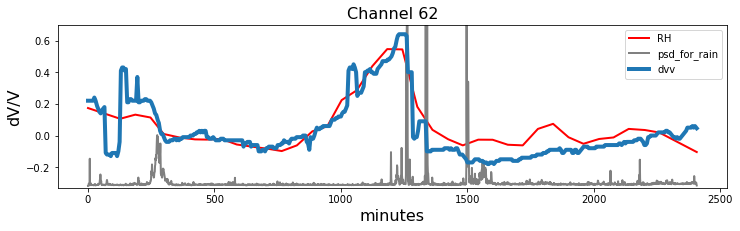

In [3]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    psd = f['psd_rain'][:]
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), (91-moisture)/50, label='RH', color='r', lw=2)
plt.plot(np.arange(len(psd)), psd *15-0.32, label='psd_for_rain', color='gray', lw=2)
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
plt.ylim(-0.33, 0.7)
plt.xlabel("minutes", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

## 2. Bulk density and porosity

,Plot,Treatments,tillage,Depth (cm),Dry Bulk density (g/cm3),Porosity (%),Moisture content (%),Rock volume (%),ind
0,1,STP Deep,25,10,1.29,51.28,13.61,2.36,35.0
3,2,LTP Deep,25,10,1.31,50.47,13.02,2.27,34.0
6,3,CTF Zero,0,10,1.22,53.98,14.56,3.55,33.0
9,4,CTF Zero,25,10,1.29,51.22,12.12,1.62,32.0
12,5,LTP Shallow,10,10,1.53,42.21,13.13,1.15,31.0


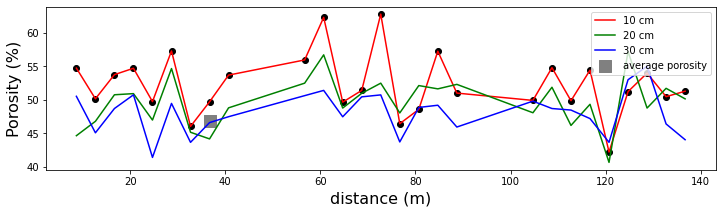

In [4]:
## read the soil physical parameters at different plots
phy_paras = pd.read_csv(data_dir + 'Soil_phy.csv')

## reverse the plot number, adding spare plots
phy_paras.loc[phy_paras['Plot'].between(1,9), 'ind'] = 36 - phy_paras.loc[phy_paras['Plot'].between(1,9), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(10,18), 'ind'] = 33 - phy_paras.loc[phy_paras['Plot'].between(10,18), 'Plot']
phy_paras.loc[phy_paras['Plot'].between(19,27), 'ind'] = 30 - phy_paras.loc[phy_paras['Plot'].between(19,27), 'Plot']
phy_paras = phy_paras.loc[phy_paras['Plot'] < 28]

## split the data into different depths
phy_10cm = phy_paras.loc[phy_paras['Depth (cm)'] == 10]
phy_20cm = phy_paras.loc[phy_paras['Depth (cm)'] == 20]
phy_30cm = phy_paras.loc[phy_paras['Depth (cm)'] == 30]

## locate the plot near channel 62
plot_ind_for_ch62 = np.round((3.19 * 12 + 3.3) / 4 ).astype(int)
bulk_density_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
bulk_density_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Dry Bulk density (g/cm3)'].values[0] * 1000
porosity_10cm = phy_10cm.loc[phy_10cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_20cm = phy_20cm.loc[phy_20cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100
porosity_30cm = phy_30cm.loc[phy_30cm['ind'] == plot_ind_for_ch62, 'Porosity (%)'].values[0] / 100

bulk_density = (bulk_density_10cm+bulk_density_20cm+bulk_density_30cm)/3
porosity = (porosity_10cm+porosity_20cm+porosity_30cm)/3

## plot the porosity at different depths, plots and near the channel 62
plt.figure(figsize=(12, 3))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), color='k')
plt.scatter(plot_ind_for_ch62*4-3.3, porosity * 100, color='gray', s=150, marker='s', label='average porosity')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Porosity (%)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Porosity (%)']), label='30 cm', color='b')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Porosity (%)", fontsize = 16)
plt.legend() 

phy_10cm.head()

## 3. Model definition
Contact model is typical for porous rock media. 

As porosity increases, the contact number will decrease. 

The contacts may slip under stress. 

Therefore, we have 2 more parameters. The totally 4 parameters are:

- Porosity (fraction of volume as fluids)
- Moisture (fraction of volume as water)
- Coordinate number N (contacts per grain)
- Non-slip fraction f (fraction of contacts)

<img src="./rock_structure.png" alt="porous rock media" width="300">

In [5]:
class litho:
    def __init__(self, bulk_density, porosity, N, f, s, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s = s  ## Saturation (water / (air + water))
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            s_rate = np.diff(self.s) / 60  ## Saturation rate, per second
            P_cdiff = np.concatenate((s_rate, [0])) * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)

        return self.vp, self.vs, self.K, self.G, self.rho

## 4. Model: Solazzi (2021) but no capillary effect

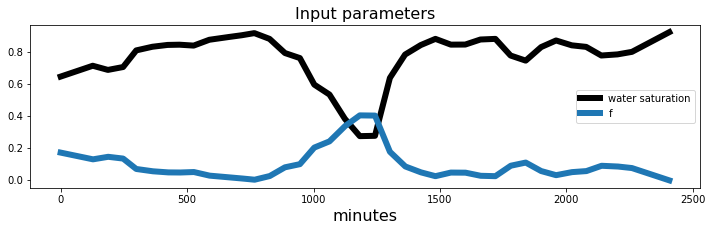

In [33]:
## Input parameters
scale_factor = moisture/100 * 2.5 - 0.6
new_f = 0.9-scale_factor/2
s=moisture/100*2-1

## residual saturation (the water content will remain with free drainage)
s_wr = 0.27

plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), s, label='water saturation', color='k', lw=6)
plt.plot(np.arange(len(new_f)), new_f, label='f', lw=6)

plt.xlabel("minutes", fontsize = 16)
plt.title("Input parameters", fontsize = 16) 
plt.legend()

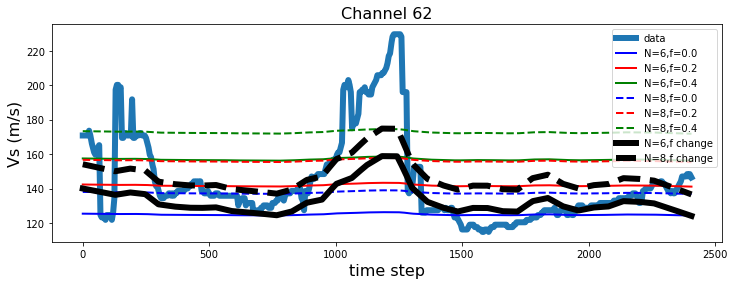

In [38]:
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, new_f, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, 0.0, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_sand2, vs_sand2, _, _, _ = litho(bulk_density, porosity, 6, 0.2, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_sand3, vs_sand3, _, _, _ = litho(bulk_density, porosity, 6, 0.4, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, new_f, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, 0.0, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay2, vs_clay2, _, _, _ = litho(bulk_density, porosity, 8, 0.2, s, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay3, vs_clay3, _, _, _ = litho(bulk_density, porosity, 8, 0.4, s, s_wr, 0, igore_capillary=True).get_vp_vs()

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(dvv)), dvv*140, label='data', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand1, label='N=6,f=0.0', color='b', lw=2)
plt.plot(np.arange(len(moisture)), vs_sand2, label='N=6,f=0.2', color='r', lw=2)
plt.plot(np.arange(len(moisture)), vs_sand3, label='N=6,f=0.4', color='g', lw=2)
plt.plot(np.arange(len(moisture)), vs_clay1, label='N=8,f=0.0', color='b', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay2, label='N=8,f=0.2', color='r', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay3, label='N=8,f=0.4', color='g', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_sand, label='N=6,f change', color='k', lw=6)
plt.plot(np.arange(len(moisture)), vs_clay, label='N=8,f change', color='k', lw=6, ls='--')

plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend(loc='upper right')

## 5. Model: Static Capillary Effect (but strong)

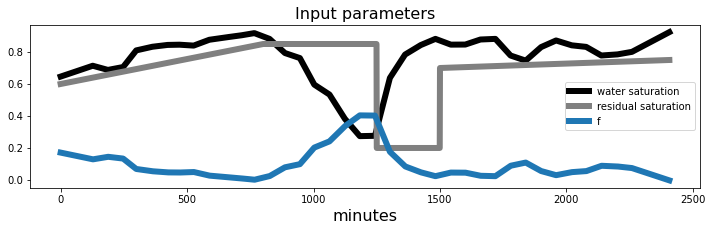

In [24]:
## Input parameters
scale_factor = moisture/100 * 2.5 - 0.6
new_f = 0.9-scale_factor/2
s=moisture/100*2-1

s_wr1 = np.linspace(0.6, 0.85, 800)
s_wr2 = 0.85*np.ones(450)
s_wr3 = 0.20*np.ones(250)
s_wr4 = np.linspace(0.7, 0.75, 908)
s_wr = np.concatenate((s_wr1, s_wr2, s_wr3, s_wr4))

plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), s, label='water saturation', color='k', lw=6)
plt.plot(np.arange(len(moisture)), s_wr, label='residual saturation', color='gray', lw=6)
plt.plot(np.arange(len(new_f)), new_f, label='f', lw=6)

plt.xlabel("minutes", fontsize = 16)
plt.title("Input parameters", fontsize = 16) 
plt.legend()


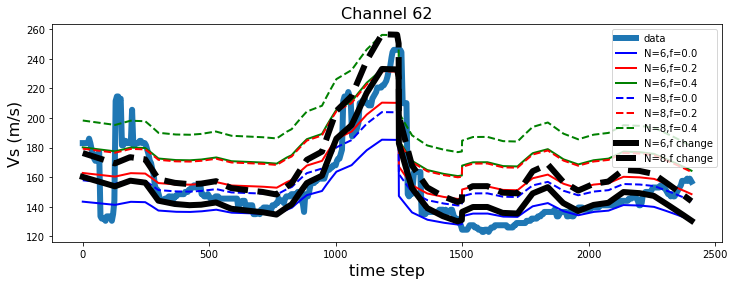

In [25]:
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, new_f, s, s_wr, 0).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, 0.0, s, s_wr, 0).get_vp_vs()
vp_sand2, vs_sand2, _, _, _ = litho(bulk_density, porosity, 6, 0.2, s, s_wr, 0).get_vp_vs()
vp_sand3, vs_sand3, _, _, _ = litho(bulk_density, porosity, 6, 0.4, s, s_wr, 0).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, new_f, s, s_wr, 0).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, 0.0, s, s_wr, 0).get_vp_vs()
vp_clay2, vs_clay2, _, _, _ = litho(bulk_density, porosity, 8, 0.2, s, s_wr, 0).get_vp_vs()
vp_clay3, vs_clay3, _, _, _ = litho(bulk_density, porosity, 8, 0.4, s, s_wr, 0).get_vp_vs()

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(dvv)), dvv*150, label='data', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand1, label='N=6,f=0.0', color='b', lw=2)
plt.plot(np.arange(len(moisture)), vs_sand2, label='N=6,f=0.2', color='r', lw=2)
plt.plot(np.arange(len(moisture)), vs_sand3, label='N=6,f=0.4', color='g', lw=2)
plt.plot(np.arange(len(moisture)), vs_clay1, label='N=8,f=0.0', color='b', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay2, label='N=8,f=0.2', color='r', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay3, label='N=8,f=0.4', color='g', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_sand, label='N=6,f change', color='k', lw=6)
plt.plot(np.arange(len(moisture)), vs_clay, label='N=8,f change', color='k', lw=6, ls='--')

plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend(loc='upper right')

## 6. Model: Dynamic Capillary Effect

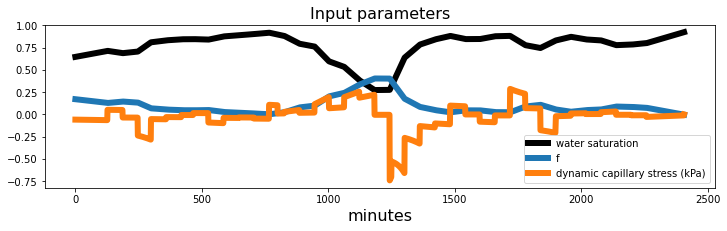

In [64]:
## Input parameters
scale_factor = moisture/100 * 2.5 - 0.6
new_f = 0.9-scale_factor/2
s=moisture/100*2-1

s_wr = 0.27  ## residual saturation
   
tau1 = 5e6 * np.exp(np.power(s[0:800],3))  ## wetting
tau2 = 1e7 * (1-s[800:1250])  ## drying
tau3 = 5e6 * np.exp(np.power(s[1250:1900],3))  ## wetting
tau4 = 1e7 * (1-s[1900:])  ## drying
tau = np.concatenate((tau1, tau2, tau3, tau4))

s_rate = np.diff(s) / 60 ## Saturation rate, per second
p_diff = 0-np.concatenate((s_rate, [0])) * tau

plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), s, label='water saturation', color='k', lw=6)
plt.plot(np.arange(len(new_f)), new_f, label='f', lw=6)
plt.plot(np.arange(len(p_diff)), p_diff/1000, label='dynamic capillary stress (kPa)', lw=6)
plt.xlabel("minutes", fontsize = 16)
plt.title("Input parameters", fontsize = 16) 
plt.legend()

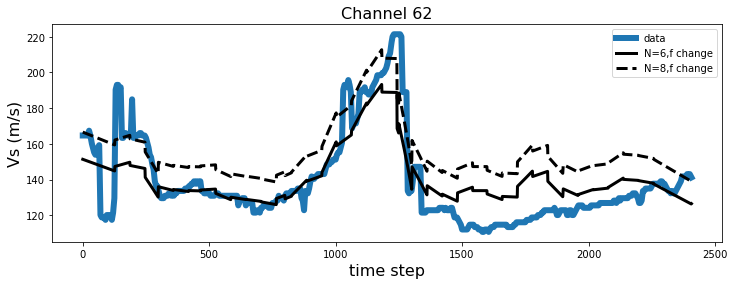

In [65]:
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, new_f, s, s_wr, tau).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, 0.0, s, s_wr, tau).get_vp_vs()
vp_sand2, vs_sand2, _, _, _ = litho(bulk_density, porosity, 6, 0.2, s, s_wr, tau).get_vp_vs()
vp_sand3, vs_sand3, _, _, _ = litho(bulk_density, porosity, 6, 0.4, s, s_wr, tau).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, new_f, s, s_wr, tau).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, 0.0, s, s_wr, tau).get_vp_vs()
vp_clay2, vs_clay2, _, _, _ = litho(bulk_density, porosity, 8, 0.2, s, s_wr, tau).get_vp_vs()
vp_clay3, vs_clay3, _, _, _ = litho(bulk_density, porosity, 8, 0.4, s, s_wr, tau).get_vp_vs()

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(dvv)), dvv*135, label='data', lw=6)
# plt.plot(np.arange(len(moisture)), vs_sand1, label='N=6,f=0.0', color='b', lw=2)
# plt.plot(np.arange(len(moisture)), vs_sand2, label='N=6,f=0.2', color='r', lw=2)
# plt.plot(np.arange(len(moisture)), vs_sand3, label='N=6,f=0.4', color='g', lw=2)
# plt.plot(np.arange(len(moisture)), vs_clay1, label='N=8,f=0.0', color='b', lw=2, ls='--')
# plt.plot(np.arange(len(moisture)), vs_clay2, label='N=8,f=0.2', color='r', lw=2, ls='--')
# plt.plot(np.arange(len(moisture)), vs_clay3, label='N=8,f=0.4', color='g', lw=2, ls='--')
plt.plot(np.arange(len(moisture)), vs_sand, label='N=6,f change', color='k', lw=3)
plt.plot(np.arange(len(moisture)), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')

plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend(loc='upper right')